In [49]:
# Import libraries
import yfinance as yf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Moving Average Crossover Strategy Analysis

In this analysis, we implement a modified strategy using two moving averages:

- **Fast Moving Average (`FAST_MA`)**: A shorter period moving average, responding more quickly to price changes with a 50 day period.
- **Slow Moving Average (`SLOW_MA`)**: The traditional 200-day moving average, providing a longer-term trend signal.

### Strategy Overview
Rather than comparing the stock price to the 200-day MA, we examine the crossovers between the FAST_MA and SLOW_MA. By buying when the FAST_MA crosses above the SLOW_MA (a bullish signal) and selling when it crosses below (a bearish signal), we aim to determine if this dual moving average approach can improve returns compared to the single moving average strategy.



In [50]:
# Define variables
SYMBOL = "^GSPC"
FAST_MA = 50
SLOW_MA = 200
STARTING_BALANCE = 10000

In [51]:
# Define time period
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2024, 1, 1)
YEARS = (END - START).days / 365.25

In [52]:
# Load data into a pandas dataframe
price = yf.download(SYMBOL, start=START, end=END)

price.head()

[*********************100%%**********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971  1455.219971   
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1399.420044   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1402.109985   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1403.449951   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1441.469971   

                Volume  
Date                    
2000-01-03   931800000  
2000-01-04  1009000000  
2000-01-05  1085500000  
2000-01-06  1092300000  
2000-01-07  1225200000

In [53]:
# Drop redundant columns
price = price.drop(['High', 'Low', 'Volume', 'Adj Close'], axis=1)

price.head()

Open        Close
Date                                
2000-01-03  1469.250000  1455.219971
2000-01-04  1455.219971  1399.420044
2000-01-05  1399.420044  1402.109985
2000-01-06  1402.109985  1403.449951
2000-01-07  1403.449951  1441.469971

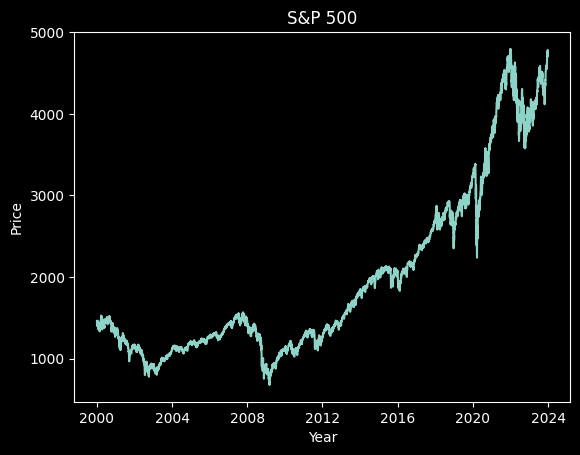

In [54]:
# Plot chart
plt.style.use('dark_background')
plt.plot(price.Close)

plt.title('S&P 500')
plt.xlabel('Year')
plt.ylabel('Price')

plt.show()

In [55]:
# Calculate daily return
price['Return'] = price.Close / price.Close.shift(1)

price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

price.tail()

Open        Close    Return     Bench_Bal
Date                                                        
2023-12-22  4753.919922  4754.629883  1.001660  32672.929032
2023-12-26  4758.859863  4774.750000  1.004232  32811.190721
2023-12-27  4773.450195  4781.580078  1.001430  32858.125743
2023-12-28  4786.439941  4783.350098  1.000370  32870.288987
2023-12-29  4782.879883  4769.830078  0.997174  32777.381936

## Calculate Benchmark Drawdown

- **Benchmark Peak**: Tracks the highest cumulative balance reached by the benchmark over time.
- **Benchmark Drawdown**: Calculates the difference between the current balance and the peak to determine any declines from the peak.

The minimum drawdown percentage (`bench_dd`) is calculated to assess the maximum loss from peak value during the period.


In [56]:
# Calculate drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()

price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round((((price.Bench_DD / price.Bench_Peak).min()) * 100), 2)

## Calculate Fast and Slow Moving Averages

- **Fast Moving Average**: Uses a shorter window (`FAST_MA`) to capture short-term trends.
- **Slow Moving Average**: Uses a 200-day window (`SLOW_MA`) to reflect long-term trends.

The table displays the last few rows with both moving averages.


In [57]:
# Calculate moving averages
price['Fast_MA'] = price.Close.rolling(window = FAST_MA).mean()
price['Slow_MA'] = price.Close.rolling(window = SLOW_MA).mean()

price.tail()

Open        Close    Return     Bench_Bal    Bench_Peak  \
Date                                                                         
2023-12-22  4753.919922  4754.629883  1.001660  32672.929032  32961.065373   
2023-12-26  4758.859863  4774.750000  1.004232  32811.190721  32961.065373   
2023-12-27  4773.450195  4781.580078  1.001430  32858.125743  32961.065373   
2023-12-28  4786.439941  4783.350098  1.000370  32870.288987  32961.065373   
2023-12-29  4782.879883  4769.830078  0.997174  32777.381936  32961.065373   

              Bench_DD      Fast_MA      Slow_MA  
Date                                              
2023-12-22 -288.136341  4468.218584  4335.861046  
2023-12-26 -149.874651  4477.157988  4340.426846  
2023-12-27 -102.939630  4485.316992  4345.055946  
2023-12-28  -90.776386  4493.519990  4349.376246  
2023-12-29 -183.683436  4502.624590  4353.765747

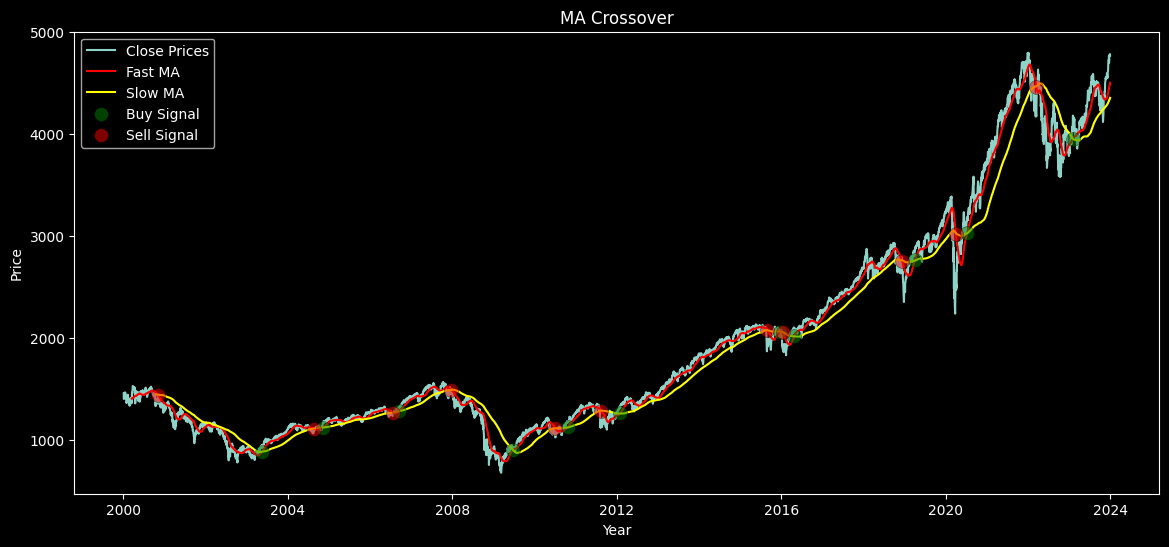

In [58]:
# Draw graph with crossover circles
plt.figure(figsize=(14, 6))
plt.plot(price.Close, label="Close Prices")
plt.plot(price.Fast_MA, color="red", label="Fast MA")
plt.plot(price.Slow_MA, color="yellow", label="Slow MA")

# Identify crossover points where the Fast_MA crosses above or below the Slow_MA
buy_signals = (price['Fast_MA'] > price['Slow_MA']) & (price['Fast_MA'].shift(1) <= price['Slow_MA'].shift(1))
sell_signals = (price['Fast_MA'] < price['Slow_MA']) & (price['Fast_MA'].shift(1) >= price['Slow_MA'].shift(1))

# Plot buy signals with green circles
plt.scatter(price.index[buy_signals], price['Fast_MA'][buy_signals], 
            color='green', edgecolor='black', s=100, linewidth=0.5, alpha=0.5, label='Buy Signal', zorder=3)

# Plot sell signals with red circles
plt.scatter(price.index[sell_signals], price['Fast_MA'][sell_signals], 
            color='red', edgecolor='black', s=100, linewidth=0.5, alpha=0.5, label='Sell Signal', zorder=3)

plt.title("MA Crossover")
plt.xlabel("Year")
plt.ylabel("Price")

plt.legend()
plt.show()

## Define Entry Signals Based on Moving Average Crossover

The chart above highlights crossover points between the Fast Moving Average (`FAST_MA`) and the Slow Moving Average (`SLOW_MA`), which serve as entry signals.

- **Long Position**: A long position is initiated (True) when the `FAST_MA` crosses above the `SLOW_MA`, indicating a bullish trend.

In [60]:
# Define entries
price['Long'] = price.Fast_MA > price.Slow_MA

price.tail()

Open        Close    Return     Bench_Bal    Bench_Peak  \
Date                                                                         
2023-12-22  4753.919922  4754.629883  1.001660  32672.929032  32961.065373   
2023-12-26  4758.859863  4774.750000  1.004232  32811.190721  32961.065373   
2023-12-27  4773.450195  4781.580078  1.001430  32858.125743  32961.065373   
2023-12-28  4786.439941  4783.350098  1.000370  32870.288987  32961.065373   
2023-12-29  4782.879883  4769.830078  0.997174  32777.381936  32961.065373   

              Bench_DD      Fast_MA      Slow_MA  Long  
Date                                                    
2023-12-22 -288.136341  4468.218584  4335.861046  True  
2023-12-26 -149.874651  4477.157988  4340.426846  True  
2023-12-27 -102.939630  4485.316992  4345.055946  True  
2023-12-28  -90.776386  4493.519990  4349.376246  True  
2023-12-29 -183.683436  4502.624590  4353.765747  True

## Calculate System Balance

- **System Return (`Sys_Ret`)**: The return for each day is based on the previous day's `Long` position. If a position is held (`Long` is True), the return is the daily return; otherwise, it's set to 1 (no change).
- **System Balance (`Sys_Bal`)**: The cumulative balance is calculated by applying the system returns (`Sys_Ret`) to the initial balance (`STARTING_BALANCE`), tracking growth over time.

The table below displays the last few rows, including the calculated system returns and balance.


In [61]:
# Calculate system balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)

price['Sys_Bal'] = STARTING_BALANCE * price.Sys_Ret.cumprod()

price.tail()

Open        Close    Return     Bench_Bal    Bench_Peak  \
Date                                                                         
2023-12-22  4753.919922  4754.629883  1.001660  32672.929032  32961.065373   
2023-12-26  4758.859863  4774.750000  1.004232  32811.190721  32961.065373   
2023-12-27  4773.450195  4781.580078  1.001430  32858.125743  32961.065373   
2023-12-28  4786.439941  4783.350098  1.000370  32870.288987  32961.065373   
2023-12-29  4782.879883  4769.830078  0.997174  32777.381936  32961.065373   

              Bench_DD      Fast_MA      Slow_MA  Long   Sys_Ret       Sys_Bal  
Date                                                                            
2023-12-22 -288.136341  4468.218584  4335.861046  True  1.001660  41394.475715  
2023-12-26 -149.874651  4477.157988  4340.426846  True  1.004232  41569.644282  
2023-12-27 -102.939630  4485.316992  4345.055946  True  1.001430  41629.107902  
2023-12-28  -90.776386  4493.519990  4349.376246  True  1.000370  41644.517940  
2023-12-29 -183.683436  4502.624590  4353.765747  True  0.997174  41526.810751

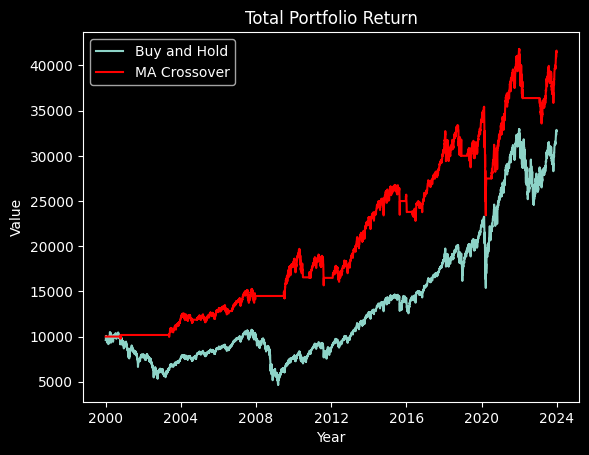

In [13]:
plt.plot(price.Bench_Bal, label="Buy and Hold")
plt.plot(price.Sys_Bal, color="red", label="MA Crossover")

plt.title("Total Portfolio Return")
plt.xlabel("Year")
plt.ylabel("Value")

plt.legend()

plt.show()

## Calculate System Drawdown

We use a similar approach as the previous analysis to calculate the System Drawdown. This helps us understand what is the biggest decline that has happened by following the MA Crossover strategy during the selected period.

- **System Peak (`Sys_Peak`)**: Tracks the highest value reached by the system balance (`Sys_Bal`) over time.
- **System Drawdown (`Sys_DD`)**: Measures the decline from the peak value to the current system balance, indicating potential losses.
- **Maximum Drawdown**: The maximum drawdown is calculated as the largest percentage decline from the peak.

The result (`sys_dd`) represents the system's maximum drawdown of -33.92%.


In [62]:
# Calculate drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()

price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round((((price.Sys_DD / price.Sys_Peak).min()) * 100), 2)

print(sys_dd)

-33.92


## Calculate Performance Metrics

We calculate the key performance metrics as we did in the last analysis for both the benchmark and the system strategy:

- **Total Return**: Measures the overall percentage change in value.
- **CAGR (Compound Annual Growth Rate)**: Calculates the annual growth rate over the period.
- **Drawdown**: Measures the maximum loss from a peak value.
- **Time in Market**: Tracks the percentage of time the system holds a position.

The calculated metrics are printed for both the benchmark and system strategies to assess and compare their performance.


In [63]:
# Calculate metrics
bench_return = round(((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[1]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[1])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_tim = round((price.Long.sum() / price.shape[0]) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'System Time in the Market: {sys_tim}%')

Benchmark Total return: 240.84%
Benchmark CAGR: 5.24
Benchmark DD: -56.78%

System Total return: 315.27%
System CAGR: 6.11
System DD: -33.92%
System Time in the Market: 66.52%


## Backtest Function with Dual Moving Averages

The `backtest` function evaluates a strategy using two moving averages:

- **Inputs**:
  - `price`: DataFrame containing stock price data.
    
  - `period_fast`: The window for calculating the fast moving average.
    
  - `period_slow`: The window for calculating the slow moving average.

- **Calculations**:
  - **Fast and Slow Moving Averages**: Calculates both moving averages based on the given periods.
    
  - **Entry Signal**: Buys when the Fast Moving Average crosses above the Slow Moving Average.
 
  - **System Return**: Calculates daily returns based on positions held, with a return of 1 on non-trading days.
 
  - **System Balance**: Tracks the cumulative balance using the system return.

- **Output**: Returns the Compound Annual Growth Rate (CAGR) for the system strategy based on the dual moving average crossover.


In [64]:
def backtest(price, period_fast, period_slow):
    # Calculate moving averages
    price['Fast_MA'] = price.Close.rolling(window = period_fast).mean()
    price['Slow_MA'] = price.Close.rolling(window = period_slow).mean()

    # Hold a position for every day the close is above the MA
    price['Long'] = price.Fast_MA > price.Slow_MA
    
    # On days when there is no trade, return is 1
    price['Sys_Return'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    
    # Calculate balance
    price['Sys_Balance'] = STARTING_BALANCE * price.Sys_Return.cumprod()
    cagr_system = (((price.Sys_Balance.iloc[-1]/price.Sys_Balance.iloc[0])**(1/YEARS))-1)*100
    
    return cagr_system

## Evaluating Optimal Moving Average Combinations

Using the backtest function, we explore the performance of various moving average combinations to identify the most effective pairing for maximising returns.

- **Period Ranges**:
  - `periods_slow`: Slow moving average windows ranging from 175 to 300 days, incremented by 5.

  - `periods_fast`: Fast moving average windows ranging from 5 to 150 days, incremented by 5.

- **Backtesting Loop**: For each slow period, the backtest is run across all fast periods, with the resulting CAGR values saved in a nested list (`results_full`). This enables analysis of the strategy’s performance across a broad set of moving average combinations.

These results will help identify the fast and slow moving average pairings that deliver the highest returns.


In [65]:
periods_slow = []
periods_fast = []
periods_slow.extend(range(175, 305, 5))
periods_fast.extend(range(5, 155, 5))

cagr = {}

results_full = []

for slow in periods_slow:
    results_fast = []
    for fast in periods_fast:
        result = backtest(price, fast, slow)
        results_fast.append(result)
    results_full.append(results_fast)

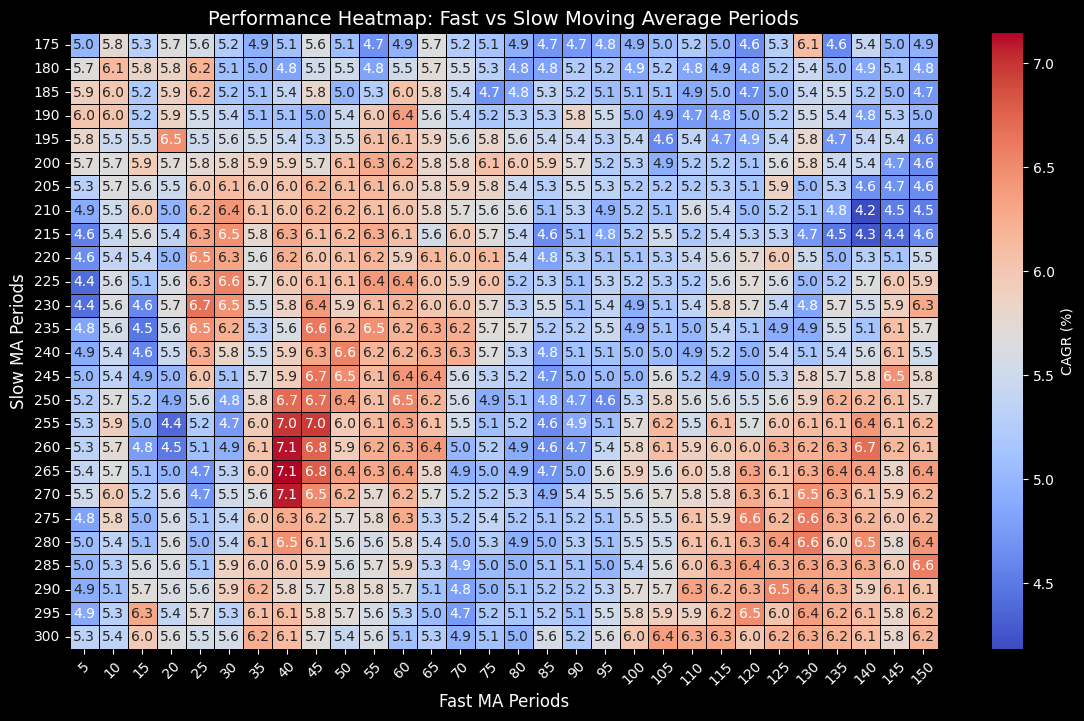

In [66]:
plt.figure(figsize=(14, 8))

# Plot heatmap
sns.heatmap(
    results_full,
    cmap="coolwarm",
    xticklabels=periods_fast,
    yticklabels=periods_slow,
    linewidth=0.5,
    linecolor="black",
    annot=True,  # Display values in each cell
    fmt=".1f",   # Format annotation to one decimal place
    cbar_kws={'label': 'CAGR (%)'}  # Label for colour bar
)


# Labels and title
plt.xlabel("Fast MA Periods", fontsize=12)
plt.ylabel("Slow MA Periods", fontsize=12)
plt.title("Performance Heatmap: Fast vs Slow Moving Average Periods", fontsize=14)

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()


## Heatmap Analysis for Optimal CAGR

The heatmap above illustrates the highest Compound Annual Growth Rates (CAGRs) achieved across different combinations of Fast and Slow Moving Average periods. Each cell represents a unique pairing, with colours indicating performance—ranging from dareker blue (lower CAGR ~4.2%) to dark red (higher CAGR ~7.1). 

The darker red area on the centre-left suggests that using a Fast Moving Average of around 40 days, paired with a Slow Moving Average of approximately 265 days, yields the highest CAGR over the 24-year period analysed.


In [67]:
min_cagr= min(list(map(min, results_full)))
max_cagr = max(list(map(max, results_full)))


print(f'Min CAGR: {min_cagr}')
print(f'Max CAGR: {max_cagr}')

Min CAGR: 4.181235092845026
Max CAGR: 7.143775170310285


## Optimal Fast & Slow MA

Here we use a for loop to search through a list of lists, `results_full`, to locate a specific value, `max_cagr`. Once it finds `max_cagr`, it retrieves its position within the sublist and stores the relevant indices.

After identifying where `max_cagr` is located, it uses the indices to print out three pieces of information:

- **Fast MA**: The "Fast Moving Average" period, which corresponds to the position of `max_cagr` within the inner list.
- **Slow MA**: The "Slow Moving Average" period, associated with the outer list where `max_cagr` was found.

In [33]:
for i, x in enumerate(results_full):
    if max_cagr in x:
        s = results_full[i].index(max_cagr)
        f = i

opt_fast_ma = periods_fast[s]
opt_slow_ma = periods_slow[f]

print(f'Fast MA: {opt_fast_ma}')
print(f'Slow MA: {opt_slow_ma}')
print(f'CAGR: {round(results_full[f][s], 2)}%')

Fast MA: 40
Slow MA: 265
CAGR: 7.14%


## Maximising the return

Based on the information above we use the 40 and 265 periods for our moving average to generate reviewed results.

Here we alter the `backtest` function to perform all the calculations and return the comparison between system and benchmark.

In [68]:
def backtest(price, period_fast, period_slow):
    # Calculate moving averages
    price['Fast_MA'] = price.Close.rolling(window=period_fast).mean()
    price['Slow_MA'] = price.Close.rolling(window=period_slow).mean()

    # Determine long positions
    price['Long'] = price.Fast_MA > price.Slow_MA
    
    # Calculate system returns
    price['Sys_Return'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    
    # Calculate system balance over time
    price['Sys_Balance'] = STARTING_BALANCE * price.Sys_Return.cumprod()

    # Calculate system metrics
    sys_return = round(((price.Sys_Balance.iloc[-1] / price.Sys_Balance.iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((price.Sys_Balance.iloc[-1] / price.Sys_Balance.iloc[0]) ** (1 / YEARS)) - 1) * 100), 2)

    # Calculate drawdown
    price['Sys_Peak'] = price.Sys_Balance.cummax()
    price['Sys_DD'] = price.Sys_Balance - price['Sys_Peak']
    sys_dd = round(((price['Sys_DD'] / price['Sys_Peak']).min()) * 100, 2)

    # Calculate time in the market
    sys_tim = round((price.Long.sum() / price.shape[0]) * 100, 2)

    # Benchmark calculations (assuming Bench_Bal column exists in 'price')
    bench_return = round(((price.Bench_Bal.iloc[-1] / price.Bench_Bal.iloc[1]) - 1) * 100, 2)
    bench_cagr = round(((((price.Bench_Bal.iloc[-1] / price.Bench_Bal.iloc[1]) ** (1 / YEARS)) - 1) * 100), 2)

    # Calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price['Bench_Peak']
    bench_dd = round(((price['Bench_DD'] / price['Bench_Peak']).min()) * 100, 2)

    # Final balance differences
    total_value_diff = round((price.Sys_Balance.iloc[-1] - price.Bench_Bal.iloc[-1]), 2)
    final_pcn_diff = round((price.Sys_Balance.iloc[-1] * 100) / price.Bench_Bal.iloc[-1], 2)

    # Format and return the results as a string
    return (
        f"Benchmark Total return: {bench_return}%\n"
        f"Benchmark Total value: {price.Bench_Bal.iloc[-1]:,.2f}\n"
        f"Benchmark CAGR: {bench_cagr}%\n"
        f"Benchmark DD: {bench_dd}%\n"
        "\n"
        f"System Total return: {sys_return}%\n"
        f"System Total value: {price.Sys_Balance.iloc[-1]:,.2f}\n"
        f"System CAGR: {sys_cagr}%\n"
        f"System DD: {sys_dd}%\n"
        f"System Time in the Market: {sys_tim}%\n"
        "\n"
        f"Final return difference: {total_value_diff:,.2f}\n"
        f"Final % Difference: {final_pcn_diff}%"
    )


In [70]:
print(backtest(price, opt_fast_ma, opt_slow_ma))

Benchmark Total return: 240.84%
Benchmark Total value: 32,777.38
Benchmark CAGR: 5.24%
Benchmark DD: -56.78%

System Total return: 423.85%
System Total value: 52,384.97
System CAGR: 7.14%
System DD: -33.92%
System Time in the Market: 68.01%

Final return difference: 19,607.58
Final % Difference: 159.82%


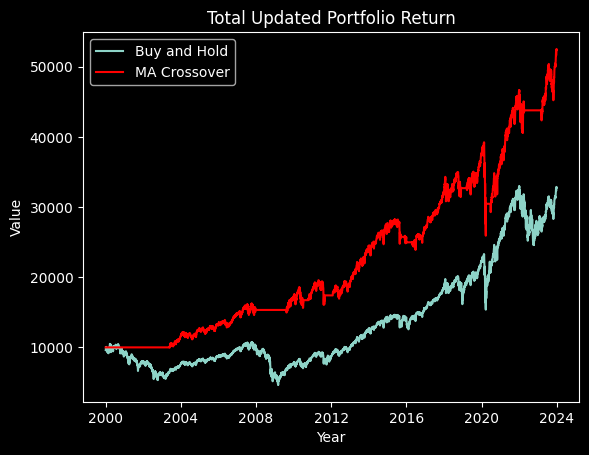

In [71]:
plt.figure()

plt.plot(price['Bench_Bal'], label="Buy and Hold")
plt.plot(price['Sys_Balance'], color="red", label="MA Crossover")

# Title and labels
plt.title("Total Updated Portfolio Return")
plt.xlabel("Year")
plt.ylabel("Value")

# Add legend and show plot
plt.legend()
plt.show()


## Conclusion

The Moving Average is a straightforward yet effective indicator that provides insights into an index's performance based on its recent trends. Its flexibility in period selection allows for a comprehensive view of market behaviour across various time frames.

In this analysis, we utilised two moving averages to guide buy and sell decisions. This approach enabled the portfolio to outperform a simple buy-and-hold strategy while maintaining a better drawdown than the benchmark and only keeping capital in the market for 2/3 of the time.

Extensive backtesting of different moving average combinations helped us identify the optimal moving averages for maximum returns over the past 24 years. The results demonstrate a significant improvement in returns compared to the benchmark, showcasing the potential of a moving average crossover strategy to enhance performance.